# Building a Vision Transformer Model

In [ ]:
import torch
import torch.nn as nn # nn sub-function that contains lots of loss fun
import torch.nn.functional as f
import torch.optim as optim # optim contains lots of optimizers functions
from torch.utils.data import dataloader
from torchvision import datasets,transforms
import numpy as np
import torchvision
import random
import matplotlib.pyplot as plt


In [ ]:
torch.__version__ # tocheck version

'2.9.0+cu126'

In [ ]:
torchvision.__version__

'0.24.0+cu126'

In [ ]:
# set device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
!nvidia-smi

Fri Dec 26 12:20:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print(f" using device:{device}")

 using device:cuda


### set the seed

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

### setting hyperparameter



Increase these

EPOCHS: 10 → 100–200
ViTs on CIFAR-10 typically need 100+ epochs to converge and reach high accuracy.
​

BATCH_SIZE: 128 → 256 (or 512 if GPU allows)
Larger batches give more stable gradients and work well with transformers on CIFAR-10.
​

MLP_DIM: 512 → 1024
Using about 4× EMBED_DIM in the MLP is standard and improves capacity.

​EMBED_DIM: 256 → 384

NUM_HEADS: 8 → 12

Optionally EMBED_DIM & NUM_HEADS:



EMBED_DIM: 256 → 384

NUM_HEADS: 8 → 12
This keeps per-head dim reasonable and can improve attention expressiveness.
​

Keep (do not change for now)

PATCH_SIZE = 4, IMAGE_SIZE = 32, NUM_CLASSES = 10, CHANNELS = 3
Patch size 4 on 32×32 is a good choice for CIFAR-10.
​

LEARNING_RATE = 3e-4 (but add warmup + decay schedule rather than changing the value).
​

DROP_RATE = 0.1 and DEPTH = 6 are reasonable for a small ViT on CIFAR-10

In [ ]:
BATCH_SIZE = 256 # play with  chanaging parameters
EPOCHS = 100
LEARNING_RATE = 3e-4
PATCH_SIZE=4
NUM_CLASSES=10
IMAGE_SIZE= 32
CHANNELS= 3
EMBED_DIM = 384
NUM_HEADS = 12
DEPTH = 4
MLP_DIM= 512
DROP_RATE= 0.3

###  5.DEFINE IMAGE TRANDFORMATIONS

In [ ]:
# 5.DEFINE IMAGE TRANDFORMATIONS commenting below line for finr tuning
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)) # normalize is mean and median
    # helps model to converge faster / helps to make the numericalcomputation stable
])

"""# fine tuning try changing the parametes to see results
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),


    transforms.ColorJitter(brightness = 0.2 ,
                           contrast= 0.2,
                           saturation=0.2,
                           hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
                           ])   """

'# fine tuning try changing the parametes to see results\ntransform_train = transforms.Compose([\n    transforms.RandomCrop(32, padding=4),\n    transforms.RandomHorizontalFlip(),\n    transforms.RandomVerticalFlip(),\n\n\n    transforms.ColorJitter(brightness = 0.2 ,\n                           contrast= 0.2,\n                           saturation=0.2,\n                           hue=0.2),\n    transforms.ToTensor(),\n    transforms.Normalize((0.5), (0.5))\n                           ])   '

In [ ]:
1e-4

0.0001

In [ ]:
#6. loading datsets
train_dataset = datasets.CIFAR10(root="data",
                                 train=True,
                                 download=True,
                                 transform=transform)

100%|██████████| 170M/170M [00:05<00:00, 30.7MB/s]


In [ ]:
test_dataset = datasets.CIFAR10(root="data",
                                 train=False,
                                 download=True,
                                 transform=transform)


In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [ ]:
len(train_dataset)

50000

In [ ]:
len(test_dataset)

10000

### converting data in to dataloaders


data is in form of pytorch

datasets - convert it in to batches(or mini batches) using Dataloader

reason:

1. more computationally efficient(batch_size of 128)

2. gives more chances to neural network to update its gradients per epoch

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

test_loader= DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [ ]:
# let's check what we have got created
print(f"DataLoader : {train_loader,test_loader}")
print(f"Length of train_loader:{len(train_loader)} batches of{BATCH_SIZE}...")
print(f"Length of test_loader:{len(test_loader)} batches of {BATCH_SIZE}...")

DataLoader : (<torch.utils.data.dataloader.DataLoader object at 0x7e782ddd7b30>, <torch.utils.data.dataloader.DataLoader object at 0x7e782de314f0>)
Length of train_loader:196 batches of256...
Length of test_loader:40 batches of 256...


### Building VIT transformer model

In [ ]:
class patchEmbedding(nn.Module):
  def __init__(self,
              img_size,
              patch_size,
              in_channels,
              embed_dim):
    super().__init__()
    self.patch_size= patch_size
    self.proj = nn.Conv2d(in_channels=in_channels,
                          out_channels=embed_dim,
                          kernel_size=patch_size,
                          stride=patch_size)
    num_patches = (img_size//patch_size)**2
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))

  def forward(self ,x:torch.Tensor):
    B = x.size(0)
    x = self.proj(x)
    x= x.flatten(2).transpose(1,2)
    cls_token = self.cls_token.expand(B,-1,-1) # Corrected: expand cls_token to match batch size
    x = torch.cat((cls_token,x),dim = 1 )
    x = x + self.pos_embed
    return x

In [ ]:
PATCH_SIZE

4

In [ ]:
class MLP(nn.Module):
  def __init__(self,
              in_features,
              hidden_features,
              drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features = in_features,
                         out_features = hidden_features)

    self.fc2 = nn.Linear(in_features= hidden_features,
                         out_features=in_features)
    self.dropout = nn.Dropout(drop_rate)


  def forward (self,x):
    x= self.dropout(f.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x



In [ ]:
class transformerEncoderLayer(nn.Module):
  def __init__(self,
              embed_dim,
              num_heads,
              mlp_dim,
              drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim,
                                      num_heads,
                                       dropout=drop_rate,
                                       batch_first= True)

    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim,mlp_dim,drop_rate)

  def forward(self,x):
    x= x + self.attn(self.norm1(x), self.norm1(x),
                     self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x




In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, # these are input that we need tomake vision transformer
               img_size,
               patch_size,
               in_channels,
               num_classes,
               embed_dim,
               depth,
               num_heads,
               mlp_dim,
               drop_rate):
    super().__init__()
    self.patch_embed = patchEmbedding(img_size,
                                      patch_size,
                                      in_channels,
                                      embed_dim)
    self.encoder = nn.Sequential(*[
        transformerEncoderLayer(embed_dim,
                                num_heads,
                                mlp_dim,
                                drop_rate)
        for _ in range(depth)
    ])
    # if we specify depth as 10 that means 10 transformer layers
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim,num_classes)

  def forward(self,x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:,0]
    return self.head(cls_token)

In [ ]:
model.state_dict() # we will get trained weights

NameError: name 'model' is not defined

In [ ]:
# instantiate model
model = VisionTransformer(IMAGE_SIZE,
                          PATCH_SIZE,
                          CHANNELS,
                          NUM_CLASSES,
                          EMBED_DIM,
                          DEPTH,
                          NUM_HEADS,
                          MLP_DIM,
                          DROP_RATE
).to(device)

In [ ]:
model # visualization of model

VisionTransformer(
  (patch_embed): patchEmbedding(
    (proj): Conv2d(3, 384, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): transformerEncoderLayer(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
      )
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=384, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=384, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
    (1): transformerEncoderLayer(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
      )
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

### define loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() # how wrong our model is
optimizer = torch.optim.Adam(model.parameters(), # willupdate model parameter to reduce loss
                             lr=LEARNING_RATE)

In [ ]:
criterion

CrossEntropyLoss()

In [ ]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

In [ ]:
def train(model,loader, optimizer,criterion):
  # set the mode of the model in to training
  model.train()

  total_loss , correct = 0,0

  for x, y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()##


    out = model(x) # forward pass(model output raw logits)
    loss = criterion(out,y) # calculate loss

    loss.backward() # perform backpropagation

    optimizer.step() # update weights gradient descent

    total_loss += loss.item() * x.size(0) #

# argmax return indesx of highest probablity
    correct += (out.argmax(1) == y).sum().item()

  return total_loss / len(loader.dataset), correct / len(loader.dataset)# normalization the loss general across all batches

In [ ]:
# evaluate model

def evaluate(model,loader,criterion):
  model.eval() # set the mode of the model in to evalauation
  correct = 0
  with torch.inference_mode():
    for x ,y  in loader:
      x , y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(1) == y).sum().item()
  return correct / len(loader.dataset)


### Training model

In [ ]:
EPOCHS

100

In [ ]:
from tqdm.auto import tqdm

In [ ]:
train_accuracies ,test_accuracies = [],[]

for epoch in  tqdm(range(EPOCHS)):
  train_loss , train_acc = train(model,train_loader,optimizer,criterion)
  test_acc = evaluate(model,test_loader,criterion)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"Epoch:{epoch+1}/{EPOCHS},Train loss:{train_loss:.4f},Train acc:{train_acc:.4f}%,Test acc:{test_acc:.4f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:1/100,Train loss:1.7923,Train acc:0.3529%,Test acc:0.4315
Epoch:2/100,Train loss:1.4864,Train acc:0.4657%,Test acc:0.5057
Epoch:3/100,Train loss:1.3655,Train acc:0.5079%,Test acc:0.5271
Epoch:4/100,Train loss:1.2810,Train acc:0.5437%,Test acc:0.5562
Epoch:5/100,Train loss:1.2131,Train acc:0.5673%,Test acc:0.5761
Epoch:6/100,Train loss:1.1539,Train acc:0.5892%,Test acc:0.5792
Epoch:7/100,Train loss:1.0970,Train acc:0.6087%,Test acc:0.5969
Epoch:8/100,Train loss:1.0473,Train acc:0.6262%,Test acc:0.6083
Epoch:9/100,Train loss:1.0072,Train acc:0.6401%,Test acc:0.6124
Epoch:10/100,Train loss:0.9563,Train acc:0.6594%,Test acc:0.6148
Epoch:11/100,Train loss:0.9204,Train acc:0.6732%,Test acc:0.6284
Epoch:12/100,Train loss:0.8767,Train acc:0.6851%,Test acc:0.6288
Epoch:13/100,Train loss:0.8416,Train acc:0.7005%,Test acc:0.6279
Epoch:14/100,Train loss:0.8066,Train acc:0.7125%,Test acc:0.6244
Epoch:15/100,Train loss:0.7629,Train acc:0.7271%,Test acc:0.6278
Epoch:16/100,Train loss:0.7312,Tra

In [ ]:
train_accuracies

[0.35292,
 0.46566,
 0.5079,
 0.54368,
 0.56726,
 0.58922,
 0.6087,
 0.6262,
 0.64006,
 0.65938,
 0.67324,
 0.68514,
 0.70054,
 0.7125,
 0.72708,
 0.73872,
 0.74994,
 0.76266,
 0.77342,
 0.78146,
 0.79414,
 0.80452,
 0.81754,
 0.82592,
 0.83366,
 0.8403,
 0.84912,
 0.8575,
 0.86844,
 0.87132,
 0.87928,
 0.88652,
 0.88676,
 0.89628,
 0.901,
 0.9027,
 0.909,
 0.91726,
 0.91744,
 0.92018,
 0.92592,
 0.92606,
 0.92868,
 0.93082,
 0.9346,
 0.93564,
 0.94098,
 0.94058,
 0.94316,
 0.94622,
 0.94504,
 0.94328,
 0.9488,
 0.94962,
 0.95132,
 0.95366,
 0.95456,
 0.95294,
 0.95536,
 0.95434,
 0.95738,
 0.957,
 0.9605,
 0.95836,
 0.96276,
 0.96338,
 0.96302,
 0.96118,
 0.96156,
 0.96126,
 0.96428,
 0.96626,
 0.9668,
 0.96556,
 0.96664,
 0.96656,
 0.9675,
 0.96636,
 0.97048,
 0.97152,
 0.9693,
 0.97034,
 0.96766,
 0.97062,
 0.97242,
 0.96936,
 0.97008,
 0.9718,
 0.97196,
 0.97414,
 0.97352,
 0.9732,
 0.97242,
 0.97452,
 0.97398,
 0.9723,
 0.97656,
 0.97418,
 0.97508,
 0.97562]

In [ ]:
test_accuracies

[0.4315,
 0.5057,
 0.5271,
 0.5562,
 0.5761,
 0.5792,
 0.5969,
 0.6083,
 0.6124,
 0.6148,
 0.6284,
 0.6288,
 0.6279,
 0.6244,
 0.6278,
 0.6389,
 0.636,
 0.6365,
 0.6357,
 0.6325,
 0.6389,
 0.6408,
 0.6388,
 0.6388,
 0.6392,
 0.6363,
 0.6385,
 0.6371,
 0.64,
 0.6395,
 0.637,
 0.6349,
 0.634,
 0.6393,
 0.6366,
 0.6387,
 0.6425,
 0.6389,
 0.637,
 0.6431,
 0.6398,
 0.6356,
 0.6379,
 0.6381,
 0.6385,
 0.6411,
 0.6316,
 0.643,
 0.643,
 0.644,
 0.6398,
 0.6381,
 0.6402,
 0.6395,
 0.6355,
 0.6406,
 0.6467,
 0.6411,
 0.6442,
 0.6385,
 0.6371,
 0.6422,
 0.6423,
 0.64,
 0.6446,
 0.6437,
 0.6372,
 0.6449,
 0.6445,
 0.6434,
 0.6486,
 0.64,
 0.6404,
 0.6422,
 0.6438,
 0.6335,
 0.6429,
 0.6416,
 0.6484,
 0.6429,
 0.6423,
 0.6458,
 0.6461,
 0.6462,
 0.6434,
 0.6442,
 0.6415,
 0.6412,
 0.644,
 0.64,
 0.6399,
 0.6441,
 0.6395,
 0.64,
 0.6458,
 0.639,
 0.6415,
 0.6387,
 0.6432,
 0.6465]

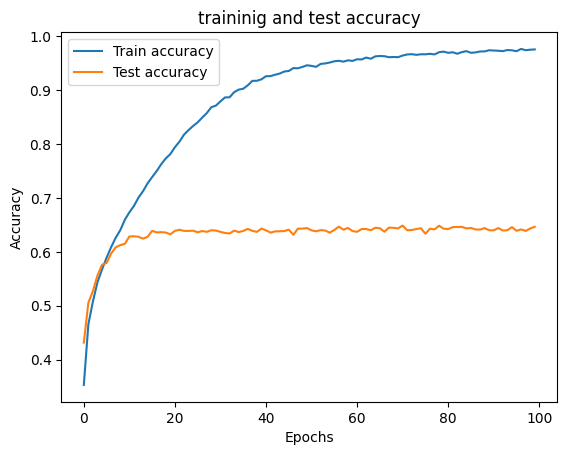

In [ ]:
#plotting
plt.plot(train_accuracies, label="Train accuracy")
plt.plot(test_accuracies, label="Test accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('traininig and test accuracy')
plt.show()

In [ ]:
import random

In [ ]:
test_dataset[0]

(tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
          [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
          [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
          ...,
          [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
          [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
          [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],
 
         [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
          [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
          [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
          ...,
          [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
          [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
          [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],
 
         [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
          [-0.6000, -0.6863,

In [ ]:
test_dataset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
test_dataset[0][0].unsqueeze(dim=0).shape # for batch size =1

torch.Size([1, 3, 32, 32])

In [ ]:
test_dataset[0][0] / 2 + 0.5 # converting -ve value to =ve B/C matplotlib  deals with =ve value only

tensor([[[0.6196, 0.6235, 0.6471,  ..., 0.5373, 0.4941, 0.4549],
         [0.5961, 0.5922, 0.6235,  ..., 0.5333, 0.4902, 0.4667],
         [0.5922, 0.5922, 0.6196,  ..., 0.5451, 0.5098, 0.4706],
         ...,
         [0.2667, 0.1647, 0.1216,  ..., 0.1490, 0.0510, 0.1569],
         [0.2392, 0.1922, 0.1373,  ..., 0.1020, 0.1137, 0.0784],
         [0.2118, 0.2196, 0.1765,  ..., 0.0941, 0.1333, 0.0824]],

        [[0.4392, 0.4353, 0.4549,  ..., 0.3725, 0.3569, 0.3333],
         [0.4392, 0.4314, 0.4471,  ..., 0.3725, 0.3569, 0.3451],
         [0.4314, 0.4275, 0.4353,  ..., 0.3843, 0.3725, 0.3490],
         ...,
         [0.4863, 0.3922, 0.3451,  ..., 0.3804, 0.2510, 0.3333],
         [0.4549, 0.4000, 0.3333,  ..., 0.3216, 0.3216, 0.2510],
         [0.4196, 0.4118, 0.3490,  ..., 0.3020, 0.3294, 0.2627]],

        [[0.1922, 0.1843, 0.2000,  ..., 0.1412, 0.1412, 0.1294],
         [0.2000, 0.1569, 0.1765,  ..., 0.1216, 0.1255, 0.1333],
         [0.1843, 0.1294, 0.1412,  ..., 0.1333, 0.1333, 0.

In [ ]:
def predict_and_plot_grid(model,
                          dataset,
                          classes,
                          grid_size=3):
  model.eval()
  fig , axes = plt.subplots(grid_size,grid_size,figsize=(10,10))
  for i in range(grid_size):
    for j in range(grid_size):
      idx = random.randint(0,len(dataset) -1) # -1 for excluding last
      img , true_label = dataset[idx]
      input_tensor = img.unsqueeze(dim=0).to(device)
      with torch.inference_mode(): # infernece to turn  off back propagations
           output = model(input_tensor)
           _, predicted = torch.max(output.data,1)
      img = img / 2 +0.5 # un-normalized
      npimg = img.cpu().numpy() # B/C numpy always use cpu
      axes[i,j].imshow(np.transpose(npimg,(1,2,0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = 'g'
      else:
        color = 'r'

      axes[i,j].set_title(f"Truth: {classes[true_label]}\n,predicted:{classes[predicted.item()]}",fontsize=10,c=color)
      axes[i,j].axis('off')
  plt.tight_layout()
  plt.show()

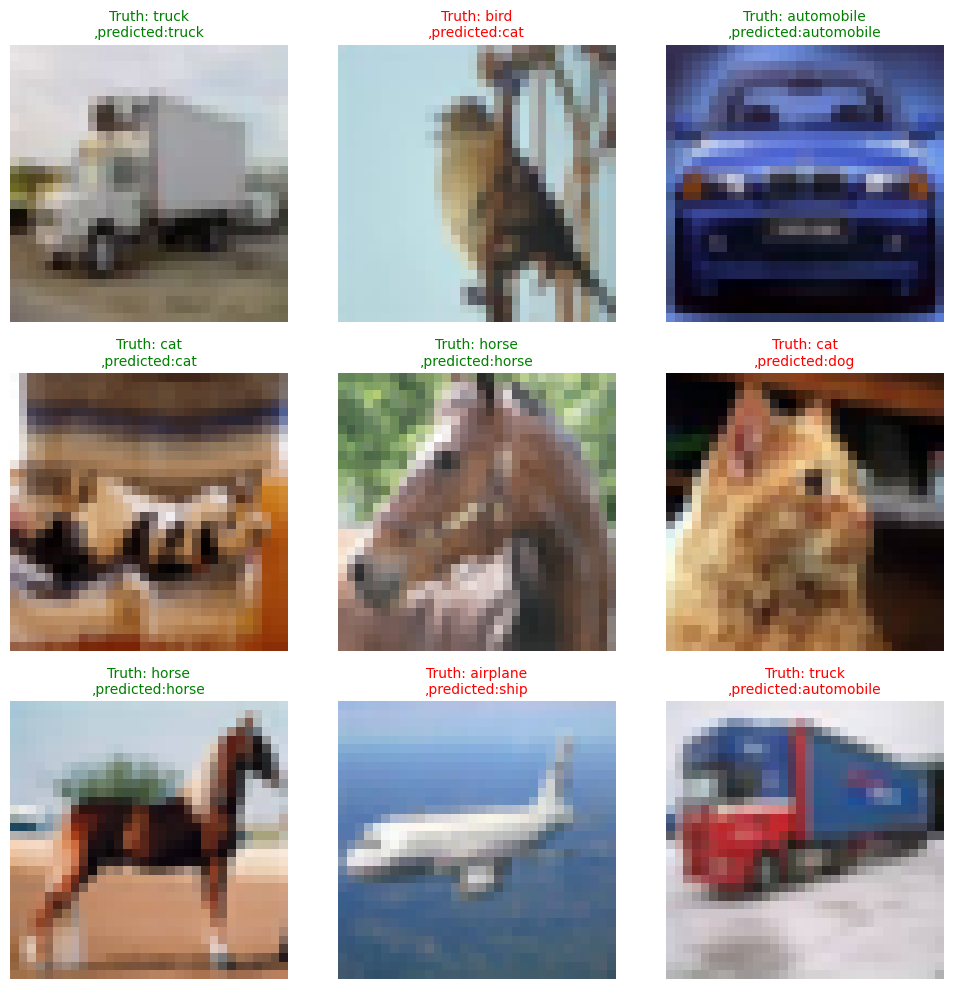

In [ ]:
predict_and_plot_grid(model,test_dataset,
                      classes=train_dataset.classes,
                      grid_size=3)

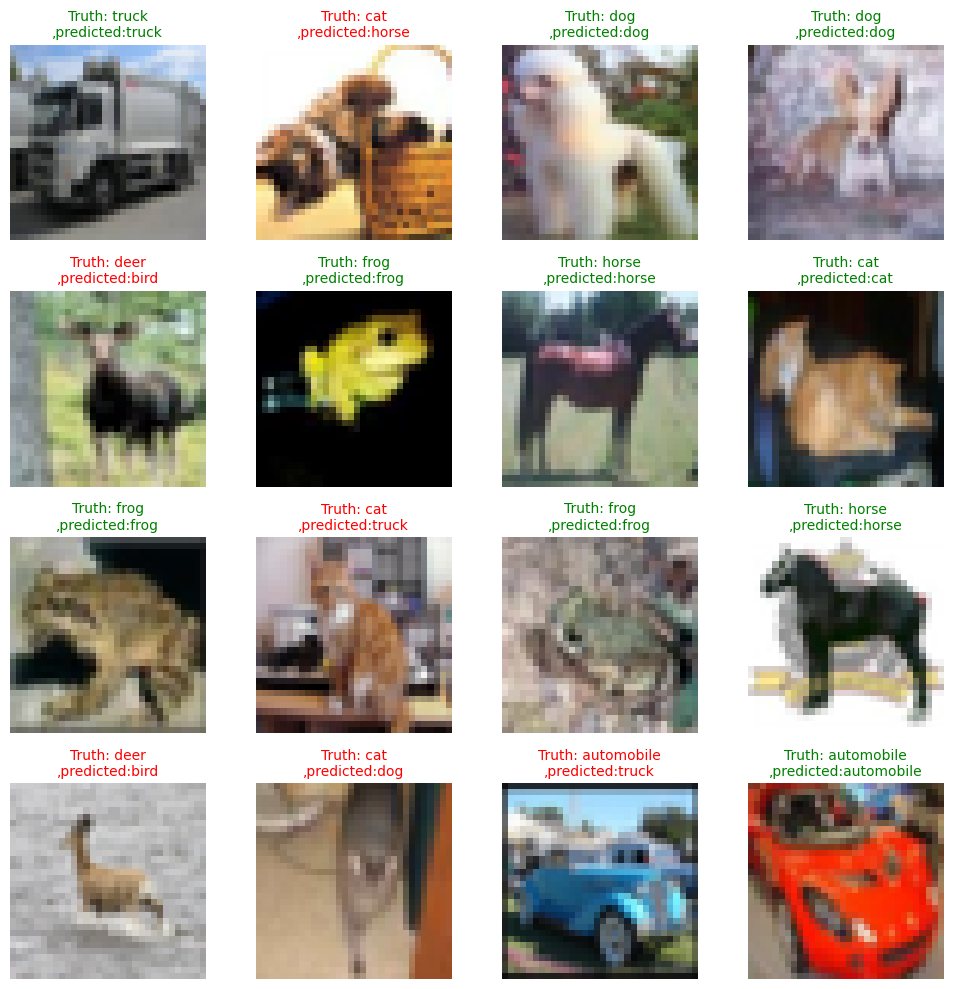

In [ ]:
predict_and_plot_grid(model,test_dataset,
                      classes=train_dataset.classes,
                      grid_size=4)

### Augumentataion to get better results


using torchvision transforms using pytorch site reading materils